In [1]:
# Imports
import os, json, random
import numpy as np
from IPython.display import JSON
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

In [2]:
# Assume the save files are in './Saves'
Raw_Saves = os.listdir('./Saves')

# How many do we have?
len(Raw_Saves)

3471

In [3]:
# Some saves may be partialy formed (Simulation stops partway or I turned it off)
# Lets remove them

_counts = {}
Runs_by_SimID = {}

for file in Raw_Saves:
    _sim_id = file.split('_')[0]
    _run_id = file.split('_')[1].split('.')[0]
    
    if _sim_id in _counts:
        _counts[_sim_id] += 1
        Runs_by_SimID[_sim_id].append(_run_id)
    else:
        _counts[_sim_id] = 1
        Runs_by_SimID[_sim_id] = [_run_id]
        
for _ in list(_counts.keys()):
    if _counts[_] != 10:
        del _counts[_]
        print('Removed malformed', _)
        
Simulation_Ids = list(_counts.keys())
print('Left with', len(Simulation_Ids), 'simulations with 10 variations each')

Removed malformed 3340168
Removed malformed 34501
Left with 346 simulations with 10 variations each


In [4]:
# Utlity
def Choose_Random_Sim ():
    return random.choice(Simulation_Ids)

def Choose_Random_Run ( sim = None ):
    if sim == None:
        return Choose_Random_Run( sim = Choose_Random_Sim() )
    return sim, random.choice(Runs_by_SimID[sim])

In [5]:
# Choose random sim and run id for demo
# These IDS are not sequential, rather they are purely random
Choose_Random_Run()

('6958408', '4215184')

In [6]:
# Populate the data from files

def Extract_Run_Data ( sim, run ):   
    with open(f'./Saves/{sim}_{run}.json') as f:
        return json.load(f)
    
def Extract_Sim_data (sim):
    result = {}
    for _run in Runs_by_SimID[sim]:
        load = Extract_Run_Data( sim, _run )
        if 'items' in result:
            result['results'].append(load['results'])
        else:
            result['items'] = load['items']
            result['positions'] = load['positions']
            result['attributes'] = load['attributes']
            result['delayedEffects'] = load['delayedEffects']
            result['results'] = [load['results']]
    return result

In [7]:
extracted_data = Extract_Sim_data( "6587074" )
JSON( extracted_data )

<IPython.core.display.JSON object>

In [8]:
# Extract all events from data

def Encode_event ( event ):
    return (event['sourceObject'],event['eventDetails'],event['relatedObject'])

def Extract_run_events ( run_result ):
    all_events = set()
    for event in run_result:
        event_info = Encode_event(event)
        all_events.add( event_info )
    return all_events

def Extract_all_events ( sim_extracted ):
    runs = sim_extracted['results']
    total = set()
    for run in runs:
        total = total.union(Extract_run_events(run))
    return list(total)

In [9]:
# All the events that ocurred across all variants of a given simulation
all_events = Extract_all_events( extracted_data )

print('There are', len(all_events), 'events in total here are 10:')
all_events[:10]

There are 7 events in total here are 10:


[('cube0', 'rolling', ''),
 ('cube0', 'left of', 'platform'),
 ('cube0', 'collide', 'platform'),
 ('cube0', 'moving', ''),
 ('cube0', 'below', 'platform'),
 ('cube0', 'right of', 'platform'),
 ('cube0', 'above', 'platform')]

In [10]:
# Extract a single event over time withing a simulation run

def Random_event ( events ):
    return random.choice(events)

def Random_run ( data ):
    return random.choice(data['results'])

def Extract_event_timeline ( target_event, run_results ):
        
    states = []
    last_state_bool = True
        
    for event in run_results:
        _encoded = Encode_event(event)
        if target_event == _encoded:
            _time = event['simulationTime']
            _val = event['newValue']
            
            states.append((_time,_val))
                
    return states

In [11]:
# Take a single event and track it through a run

Extract_event_timeline(
    Random_event( all_events ),
    Random_run( extracted_data )
)

[(0.0200042724609375, False)]

In [12]:
#Charts a timeline for a given set of intervals


def Generate_timeline_chart ( intervals, label = "" ) :
    
    verts = []
    colors = []
    _max = 8
    buffer = 0.4
    
    for i,t in enumerate(intervals):
        
        last_label = None
        last_time = 0
        
        for e in t:
            if e[0] != 0:
                verts.append([
                    (last_time, i-0.4),
                    (last_time, i+0.4),
                    (e[0], i+0.4),
                    (e[0], i-0.4),
                    (last_time, i-0.4)
                ])
                colors.append('green' if last_label else 'red')
            last_time = e[0]
            last_label = e[1]
        
    for i,t in enumerate(intervals):
        _last_item = None
        if (len(t)) == 0:
            _last_item = (0,False)
        else:
            _last_item = t[-1]
        verts.append([
            (_last_item[0], i-0.4),
            (_last_item[0], i+0.4),
            (_max+1, i+0.4),
            (_max+1, i-0.4),
            (_last_item[0], i-0.4)
        ])
        colors.append('green' if _last_item[1] else 'red')
    
    bars = PolyCollection(verts, facecolors=colors)

    fig, ax = plt.subplots(figsize=(15,len(intervals)/2))
    ax.add_collection(bars)

    ts = list(range(len(intervals)))
    ax.set_yticks(ts)
    ax.set_yticklabels(ts)
    plt.xlim(0,_max+1)
    plt.ylim(-1,len(intervals))
    plt.title(label)
    plt.show()


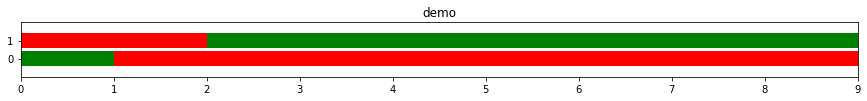

In [13]:
Generate_timeline_chart([
    [(0,True), (1,False)], 
    [(0,False), (2,True)]
], label="demo")

In [14]:
# Graph out that event timeline across all runs in a simulation

def Query_event_timelines (event, data):
    return [
        Extract_event_timeline( event, run )
        for run in data['results']
    ]

def Visualize_event_timeline ( event, data ):
    # Get all timelines and chart them for a specific event
    timelines = Query_event_timelines( event, data)
    Generate_timeline_chart( timelines, f"{event}")

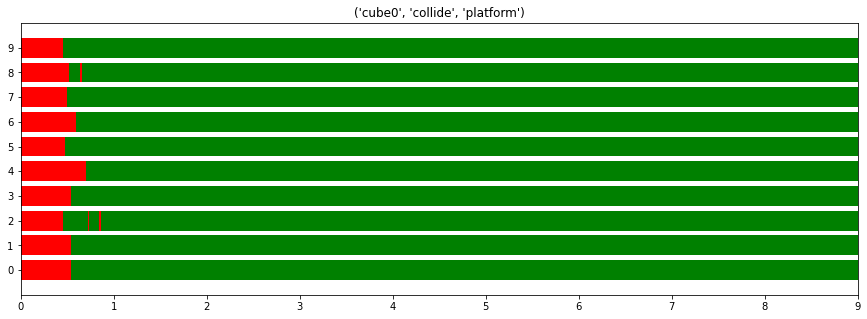

In [35]:
Visualize_event_timeline(
    Random_event( all_events ),
    extracted_data
)

In [16]:
# Extract usefull generalizations from interval graphs

def Extract_single_timeline_range (timeline, start, stop ):

    total_true = 0
    total_swaps = 0
    began = False
    sample_ends = [False,False]
    
    for i,e in enumerate(timeline):
        
        if timeline[i][0] > start and timeline[i][0] < stop:
            total_swaps += 1
        
        if i == 0: continue
        if e[0] < start: continue
        
        _begin = timeline[i-1][0]
        _end = timeline[i][0]
        _truth = timeline[i-1][1]
        
        if _begin > stop:
            sample_ends[1] = _truth
            break
        
        if _begin <= start and _end > start:
            _begin = start
            sample_ends[0] = _truth
            
        if _begin < stop and _end >= stop:
            _end = stop
            sample_ends[1] = _truth
            
        if ( _truth ):
            total_true += _end - _begin
            
        if _end >= stop: break
        
    if len(timeline) > 0:
        if timeline[-1][0] < stop and timeline[-1][1]:
            sample_ends[1] = timeline[-1][1]
            total_true += stop - timeline[-1][0]
        
    if (sample_ends[0] is True) and (sample_ends[1] is False):
        total_swaps = -total_swaps
    if sample_ends[0] == sample_ends[1]:
        total_swaps = 0
        
    percent_true = total_true / (stop - start)
    return [percent_true, total_swaps]

In [17]:
# Determines Percent Uptime & Total Swaps of timeline range
Extract_single_timeline_range(
    [(0, False), (1, True), (2, False), (3, True)],
    1,2
)

[1.0, 0]

In [18]:
def Extract_event_timeline_range ( timelines, start, stop ):

    results = []
    
    for t in timelines:
        results.append(Extract_single_timeline_range(t,start,stop) )
    
    return np.stack(results)

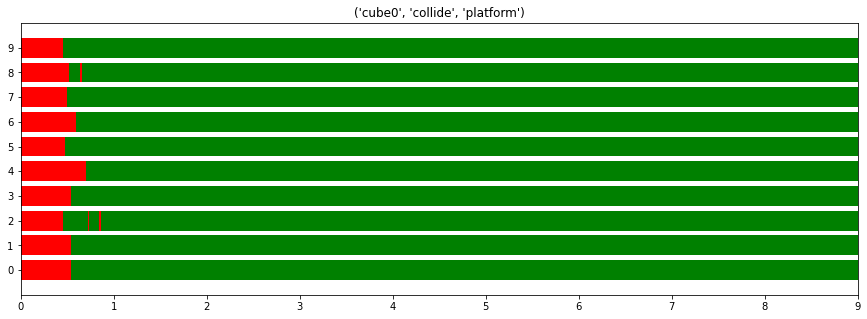

array([[0.84827292, 1.        ],
       [0.84827292, 1.        ],
       [0.86207949, 5.        ],
       [0.84827292, 1.        ],
       [0.79309924, 1.        ],
       [0.86896173, 1.        ],
       [0.8275841 , 1.        ],
       [0.86206897, 1.        ],
       [0.84827292, 3.        ],
       [0.87585449, 1.        ]])

In [19]:
# Comparison of data extracted vs graphs

_event = Random_event( all_events )

# Extract as chart
Visualize_event_timeline(
    _event,
    extracted_data
)
    
# Extract as data
Extract_event_timeline_range(
    Query_event_timelines(
        _event,
        extracted_data
    ), 0.1, 3
)

In [20]:
# Generation of statements from extracted data

def Generate_statements_from_table ( table ):
    
    active_time = table[:,0]
    toggles = table[:,1]
    
    # It is [ STATEMENT ] that event x will happen
    truthy_statements = []
    
    # Object x [ STATEMENT ] from X' to X''
    toggle_statements = []
    
    # Certain and Impossible
    
    if np.all(active_time==1):
        truthy_statements.append('certain')
    if np.all(active_time==0):
        truthy_statements.append('imposible')
        
    # Likelyness
    
    if active_time.mean() > 0.8:
        truthy_statements.append('likely')
    if active_time.mean() > 0.4:
        truthy_statements.append('reasonable')
    if active_time.mean() < 0.1:
        truthy_statements.append('unlikely')
        
        
    if active_time.max() == 1 and active_time.min() == 0:
        truthy_statements = []

    # Toggle Conditions
        
    if np.all(toggles >= 1):
        toggle_statements.append('will begin to')
    if np.all(toggles == 0) and active_time.mean() == 0:
        toggle_statements.append('will not begin to')
    if toggles.mean() >= 2:
        toggle_statements.append('may repeatedly')
    if np.all(toggles < 0):
        toggle_statements.append('will begin stoped')
      
    return truthy_statements, toggle_statements

def Generate_statements_from_event ( timelines ):
    
    _immeditely = Extract_event_timeline_range(timelines,0.05,0.3)
    _beginning = Extract_event_timeline_range(timelines,0,3)
    _after_effects = Extract_event_timeline_range(timelines,3.05,4)
    _total = Extract_event_timeline_range(timelines,0,8)
    
    return {
        'After a fraction of a second' : 
            Generate_statements_from_table(_immeditely),
        'After a few seconds of time' : 
            Generate_statements_from_table(_beginning),
        'A few seconds following these changes' : 
            Generate_statements_from_table(_after_effects),
        'Overall' : 
            Generate_statements_from_table(_total)
    }

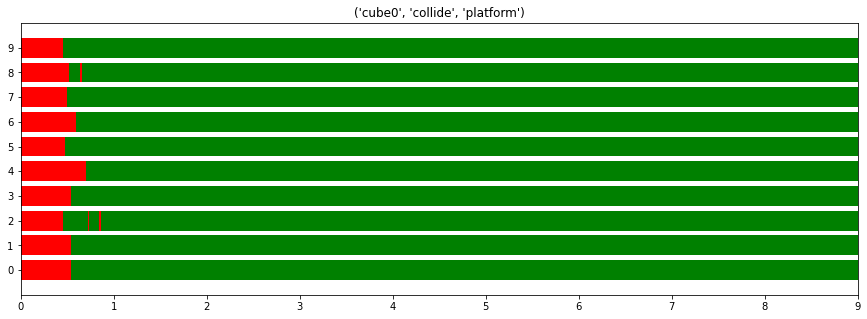

{'After a fraction of a second': (['imposible', 'unlikely'],
  ['will not begin to']),
 'After a few seconds of time': (['likely', 'reasonable'], ['will begin to']),
 'A few seconds following these changes': (['likely', 'reasonable'], []),
 'Overall': (['likely', 'reasonable'], ['will begin to'])}

In [21]:
# Now chart and get a basic description using adjectives

_event = Random_event( all_events )

Visualize_event_timeline(
    _event,
    extracted_data
)
    
Generate_statements_from_event(
    Query_event_timelines(
        _event,
        extracted_data
    )
)

In [22]:
# Generate a description of the scene with text

def Generate_counts ( scene ):
    counts = {}
    labels = {}
    for row in scene['items']:
        t = row['type']
        if t in counts:
            counts[t] += 1
        else:
            counts[t] = 1
    for row in scene['items']:
        t = row['type']
        if counts[t] == 1:
            labels[row['label']] = 'the ' + t
        else:
            labels[row['label']] = row['label']
    return counts, labels

def JoinList (items):
    
    t = ""
    
    for i,item in enumerate(items):
        t += item
        if i == len(items)-2:
            t += ', and '  
        elif i == len(items)-1:
            break
        else:
            t += ', '
            
    return t

def Describe_object_attirbutes (row, tense): 
    
    t = [['has','is'],['gains','becomes']]
    attributes = []
    a = row['attribute']
    v = row['value']

    if a == 'bouncy':
        attributes.append(t[tense][1] +' very bouncy')
    if a == 'icy':
        attributes.append('is very slipery')
    if a == 'friction':
        attributes.append(t[tense][0] +' a good amount of friction')

    if a == 'size' and v == 'small':
        attributes.append(t[tense][1] +' rather small')
    if a == 'size' and v == 'big':
        attributes.append(t[tense][1] +' rather big')
    if a == 'mass' and v == 'low':
        attributes.append(t[tense][1] +' quite light')
    if a == 'mass' and v == 'high':
        attributes.append(t[tense][1] +' quite heavy')

    if a == 'gravity' and v == 'low':
        attributes.append('experiences very little gravity')
    if a == 'gravity' and v == 'high':
        attributes.append('experiences extreme gravity')
    if a == 'gravity' and v == 'none':
        attributes.append('does not experience gravity')
    if a == 'gravity' and v == 'reversed':
        attributes.append('experiences reversed gravity')

    if a == 'pushed left':
        attributes.append('is pushed left')
    if a == 'pushed right':
        attributes.append('is pushed right')
    if a == 'pushed down':
        attributes.append('is pushed down')
    if a == 'pushed up':
        attributes.append('is pushed up')
        
    if a == 'removed':
        attributes.append('disapears')
        
    if len(attributes) == 0: return None    
    
    return attributes[0]

def Describe_properties (o, scene):
    
    attributes = []
    
    for row in scene['attributes']:
        if row['targetObject'] == o:
            _a = Describe_object_attirbutes(row,0)
            if _a is not None:
                attributes.append(_a)
        
    return JoinList(attributes)
            
def Describe_objects (scene, counts):
    
    ordinal = ['a', 'another', 'a third', 'a fourth']
    running_counts = {}
    scene_objects = []
    
    valid_items = []    
    for i,row in enumerate(scene['items']):
        if row['type'] in ['cube','ball']:
            valid_items.append(row)
    
    for i,row in enumerate(valid_items):
        
        t = row['type']
        l = row['label']
        
        if t in running_counts:
            running_counts[t] += 1
        else:
            running_counts[t] = 1
            
        prefix = ordinal[running_counts[t]-1]   
        
        text = f"{prefix} {t}"
        if counts[t] > 1:
            text += f" ({l})"
            
        described = Describe_properties(l, scene)
        if len(described) != 0:
            text += ' which ' + described
            
        scene_objects.append(text)
            
    return JoinList( scene_objects ) + '.'


def Describe_placement (scene, labels):
    positions = []
    
    prefix = "They are" if len(scene['positions']) != 1 else "It is"
    
    prefix = f"{prefix} placed {scene['positions'][0]['relationTo']} a {scene['positions'][0]['relatedObject']}"    
    
    for p in scene['positions'][1:]:
        
        o = p['targetObject']
        r = p['relationTo']
        o2 = p['relatedObject']
        
        text = f"{labels[o]} {r} of {labels[o2]}"
        positions.append(text)
        
    if len(scene['positions'][1:]) == 0:
        return prefix + '.'
    else:
        return prefix + ', ' + JoinList( positions ) + '.'

def Desctibe_effects (scene, labels):
    
    attributes = []
    for row in scene['delayedEffects']:
        effect = Describe_object_attirbutes(row,1)
        if effect is not None:
            text = f"{labels[row['targetObject']]} {effect}"
            attributes.append(text)
        
    return 'After a little bit, ' + JoinList(attributes)

def Describe_scene (scene, counts, labels):
    
    describe = 'In a simulation, there is ' + Describe_objects( scene, counts )
    positions = Describe_placement( scene, labels)
    
    in_total = describe + ' ' + positions
    
    later = Desctibe_effects(scene, labels)
    if len(scene['delayedEffects']) == 0:
        later = None
    
    return in_total, later


In [23]:
# What the scene could be described to look like

counts,labels = Generate_counts( extracted_data )
scene_description = Describe_scene( extracted_data, counts,labels )

scene_description

('In a simulation, there is a cube which experiences extreme gravity. It is placed above a platform.',
 None)

In [24]:
# Generate the possible sentences

def Describe_statements_with_event ( event, statements, labels ) :

    event_text = ""
    result_truths = []
    after_truths = []
    total_truths = []
    
    if event[1] in ['below', 'above', 'left of', 'right of']:
        event_text = f"{labels[event[0]]} is {event[1]} {labels[event[2]]}"
    if event[1] in ['rolling', 'moving']:
        event_text = f"{labels[event[0]]} is {event[1]}"
    if event[1] in ['collide']:
        event_text = f"{labels[event[0]]} collided with {labels[event[2]]}"
        
        
    for k,i in enumerate(list(statements.keys())):
        items = []
        for j in statements[i][0]:
            items.append(f"it is {j} that {event_text}")
        for j in statements[i][1]:
            if event[1] in ['below', 'above', 'left of', 'right of']:
                items.append(event_text.replace("is", j + " move"))
            if event[1] in ['rolling', 'moving']:
                items.append(event_text.replace("is", j + " be"))
            if event[1] in ['collide']:
                items.append(event_text.replace("collided", j + " collide"))
        if k == 0 or k == 1:
            result_truths.extend([ i + ', ' + item for item in items ])
        if k == 2:
            after_truths.extend([ i + ', ' + item for item in items ])
        if k == 3:
            total_truths.extend([ i + ', ' + item for item in items ])
        
    return result_truths, after_truths, total_truths


In [25]:
# Statements that were then generated

statements = Describe_statements_with_event(_event, Generate_statements_from_event(
    Query_event_timelines(
        _event,
        extracted_data
    )
), labels)

statements

(['After a fraction of a second, it is imposible that the cube collided with the platform',
  'After a fraction of a second, it is unlikely that the cube collided with the platform',
  'After a fraction of a second, the cube will not begin to collide with the platform',
  'After a few seconds of time, it is likely that the cube collided with the platform',
  'After a few seconds of time, it is reasonable that the cube collided with the platform',
  'After a few seconds of time, the cube will begin to collide with the platform'],
 ['A few seconds following these changes, it is likely that the cube collided with the platform',
  'A few seconds following these changes, it is reasonable that the cube collided with the platform'],
 ['Overall, it is likely that the cube collided with the platform',
  'Overall, it is reasonable that the cube collided with the platform',
  'Overall, the cube will begin to collide with the platform'])

In [26]:
# Quick and dirty false sentences
def Generate_false_single (s):
    
    if 'will not' in s:
        return [
            s.replace('will not', 'will')
        ]
    
    if 'will' in s:
        return [
            s.replace('will', 'will not'),
        ]
    
    if 'impossible' in s:
        return [
            s.replace('impossible', 'certain'),
            s.replace('impossible', 'likely')
        ]
    
    if 'certain' in s:
        return [
            s.replace('certain', 'impossible'),
            s.replace('certain', 'unlikely')
        ]
    
    if ' likely' in s:
        return [
            s.replace(' likely', 'impossible'),
        ]
    
    if 'reasonable' in s:
        return [
            s.replace('reasonable', 'impossible'),
        ]
    
    if 'unlikely' in s:
        return [
            s.replace('unlikely', 'certain'),
        ]
    
    return []
    
def Generate_false_full (sentences):
    
    results = []
    
    for s in sentences:
        results.extend(Generate_false_single(s))
        
    return results

In [27]:
# Remove bad sentences
def Final_pass (s):
    
    obj_base = any( a in s for a in ["box", "platform","slope", "invPyramid", "staircase", "cliff"] )
    relation = any( a in s for a in ["left", "right", "above", "below" ])
    
    if obj_base and relation:
        return None
        
    if 'the start of' in s and 'move' in s:
        return None

    return s

def Adjust_names (s):
    
    s = s.replace('a invPyramid', 'a bowl')
    s = s.replace('the invPyramid', 'the bowl')
    s = s.replace('It is placed above', 'It is placed in mid-air a bit above')
    s = s.replace('They are placed above', 'They are placed in mid-air a bit above')
    s = s.replace('slope', 'platform sloping down to the right')
    s = s.replace('staircase', 'staircase desending to the right')
    s = s.replace('cliff', 'flat platform with a cliff to the right')
    
    if ('may' in s) or ('will' in s):
        s=s.replace('after', 'across')
        s=s.replace('After', 'across')
        
    s = s[0].upper() + s[1:]
    
    return s
    
        
    
def Run_final_pass (sentences):
    
    validated = []
    for s in sentences:
        _ = Final_pass(s)
        if _ is not None:
            validated.append(Adjust_names(_))
            
    return validated

In [28]:
def Filter_bad_scenes (scene):
    for row in scene['attributes']:
        if row['attribute'] == 'removed':
            return True
    return False

In [29]:
# Hopefully putting it all together

def Process_Simulation ( simulation ):
    
    # Pull the simulation from files into memory as object
    simulation_data = Extract_Sim_data( simulation )
    
    # Pull questionable scenes as they apeared
    if Filter_bad_scenes(simulation_data):
        return None
    
    # Count the objects and label them and their types
    counts,labels = Generate_counts( simulation_data )
    
    # Describe the scene in plain text
    first, seccond = Describe_scene( simulation_data, counts, labels )
    first = Adjust_names(first)
    
    # List all the simulation events that occured
    sim_events = Extract_all_events( simulation_data )
    
    # List of statements generated from the scene
    initial = []
    after_change = []
    overall = []
    
    # Go through every event and extract the statements generated from them
    for event in sim_events:
    
        _statements = Describe_statements_with_event(
            event, 
            Generate_statements_from_event(
                Query_event_timelines(
                    event,
                    simulation_data
                )
            ), labels)
        
        # Add them to the categlories
        initial.extend(Run_final_pass(_statements[0]))
        after_change.extend(Run_final_pass(_statements[1]))
        overall.extend(Run_final_pass(_statements[2]))
        
    # Export as JSON!
    output_json = {
        "simulation_id" : simulation,
        "scene" : first,
        "true_scene" : initial,
        "false_scene": Generate_false_full(initial),
        "effects" : seccond,
        "true_effects": after_change,
        "false_effects": Generate_false_full(after_change),
        "true_total": overall,
        "false_total": Generate_false_full(overall)
    }
    
    return output_json

In [30]:
DONE = Process_Simulation("6587074")
JSON(DONE)

<IPython.core.display.JSON object>

In [31]:
for i,s in enumerate(Simulation_Ids):
    print(f"{i} / {len(Simulation_Ids)-1}", end='\r')
    with open(f'./Results/{s}.json', 'w') as outfile:
        results = Process_Simulation(s)
        if results is not None: 
            json.dump(results, outfile)